# Deflating Movie Ratings
### Author: Salvatore Porcheddu
### Date: 2021-04-10

## Introduction

In 2015 Walt Hickey at [FiveThirtyEight](https://fivethirtyeight.com/) [analyzed movie ratings](https://fivethirtyeight.com/features/fandango-movies-ratings/) data on the popular online movie ratings aggregator [Fandango](https://www.fandango.com/) and concluded that the movie ratings were being inflated by sistematically rounding them up to the next highest half (for example, a movie rated 4.1 would be artificially rated at 4.5 stars (out of five), and a movie rated 4.5 would be rounded up to a rating of 5). 

At the time Fandango replied that the [rounding up was caused by a glitch](https://www.theverge.com/2015/10/15/9545427/fandango-movie-reviews-inflated-stars) and that they would promptly fix it. But did this really happen? In this project, we will try to answer this question.

## The datasets

In order to determine whether Fandango actually addressed the problem or not, we will make use of and compare two datasets:
- the first contains the data that Walt Hickey analyzed and it's available [here](https://github.com/fivethirtyeight/data/tree/master/fandango)
- the second consists of movie ratings from 2016 and 2017 and it's available [here](https://github.com/mircealex/Movie_ratings_2016_17).

Let's read in the datasets and do some basic exploratory analysis:

In [2]:
import numpy as np
import pandas as pd

movie_ratings_15 = pd.read_csv("fandango_score_comparison.txt")
movie_ratings_16_17 = pd.read_csv("movie_ratings_16_17.txt")

# let's see the first five rows from each dataset
print("movie_ratings_15 data set:")
movie_ratings_15.head()

movie_ratings_15 data set:


,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [3]:
print("movie_ratings_16_17 data set:")
movie_ratings_16_17.head()

movie_ratings_16_17 data set:


,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


In [4]:
# let's see some general information about the datasets
print(movie_ratings_15.info())
print(movie_ratings_16_17.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FILM                        146 non-null    object 
 1   RottenTomatoes              146 non-null    int64  
 2   RottenTomatoes_User         146 non-null    int64  
 3   Metacritic                  146 non-null    int64  
 4   Metacritic_User             146 non-null    float64
 5   IMDB                        146 non-null    float64
 6   Fandango_Stars              146 non-null    float64
 7   Fandango_Ratingvalue        146 non-null    float64
 8   RT_norm                     146 non-null    float64
 9   RT_user_norm                146 non-null    float64
 10  Metacritic_norm             146 non-null    float64
 11  Metacritic_user_nom         146 non-null    float64
 12  IMDB_norm                   146 non-null    float64
 13  RT_norm_round               146 non

The two data sets contain a combined total of 37 variables: that is a lot of data and we actually won't need most of it; so, let's filter our dataframes to only include the variables related to Fandango's ratings:

In [5]:
mr_15 = movie_ratings_15.loc[:,["FILM", "Fandango_Stars", "Fandango_Ratingvalue", "Fandango_votes", "Fandango_Difference"]].copy()
mr_16_17 = movie_ratings_16_17.loc[:,["movie", "year", "fandango"]].copy()

# let's display the first five rows of the filtered dataframes
print("mr_15 filtered data set:")
mr_15.head()

mr_15 filtered data set:


,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [6]:
print("mr_16_17 filtered data set:")
mr_16_17.head()

mr_16_17 filtered data set:


,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


As noted in Walt Hickey's article, all the movies that he sampled were at least somewhat popular (30 or more user reviews) and all movies for which Fandango sold tickets: intuitively, it's not hard to imagine that a company may have interest to inflate a movie rating if they sell tickets for that movie.

As a consequence, we can't say that Walt Hickey's data set was sampled randomly and therefore it is not representative of the entire population of movies rated by Fandango's users.

Similarly, the `movie_rating_16_17` dataset was also NOT randomly sampled: only movies released in 2016 or 2017 with a certain number of votes and reviews were taken into consideration.

Therefore, we lack the data to conduct a thorough analysis that would sample from the entire population of movies rated by Fandango's users, but rather we can only focus on movies released within a relatively short timespan and that have enjoyed at least a certain degree of popularity.

Our new goal then becomes to compare whether Fandango's rating system for popular movies (movies with at least 30 fan ratings) changed after Walt Hickey's article was published in 2015. With this new objective in mind, we will only consider the 2015 movie data for the "before" component of our analysis and the 2016 movie data for the "after" component.

In [7]:
# making sure that all movies in mr_15 have at least 30 fan ratings
mr_15 = mr_15[mr_15["Fandango_votes"] >= 30]
print("The least popular movie in the filtered mr_15 has {0} fan ratings".format(mr_15["Fandango_votes"].min()))

# making sure that all movies in mr_15 were released in 2015
mr_15["Year"] = mr_15["FILM"].str.extract("(20[0-9]+)")
print(mr_15["Year"].value_counts())

The least popular movie in the filtered mr_15 has 35 fan ratings
2015    129
2014     17
Name: Year, dtype: int64


In [8]:
# 17 movies were released in 2014 and we will therefore remove them
mr_15 = mr_15[mr_15["Year"] != "2014"]
print("We now have {0} movies left in the dataframe".format(mr_15.shape[0]))
mr_15.head()

We now have 129 movies left in the dataframe


,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015
3,Do You Believe? (2015),5.0,4.5,1793,0.5,2015
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,2015


Our second data set, `mr_16_17`, does not allow us to directly check whether the movies have at least 30 fan ratings, although the creator states that the movies were sampled from the most popular movies in 2016 and 2017.

To be completely sure that the movies are indeed popular, after removing any 2017 movie we will randomly sample ten movies and check their fan ratings on Fandango:

In [9]:
# removing 2017 movies
mr_16 = mr_16_17[mr_16_17["year"] == 2016]
print(mr_16["year"].value_counts())
mr_16.head()

2016    191
Name: year, dtype: int64


,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
4,A Hologram for the King,2016,3.0
5,A Monster Calls,2016,4.0


In [10]:
# sampling ten movies and assigning them to a new series
ten_sample = mr_16["movie"].sample(n=10, random_state=1)
ten_sample.reset_index(drop=True, inplace=True)
ten_sample

0                            Collide
1          Ice Age: Collision Course
2                   Now You See Me 2
3           The Disappointments Room
4           Kubo and the Two Strings
5    Pride and Prejudice and Zombies
6                           Deadpool
7                      Money Monster
8                           War Dogs
9               Miracles from Heaven
Name: movie, dtype: object

In [11]:
# getting the number of fan ratings from Fandango and storing them in a list
ten_ratings = [2500, 25000, 50000, 2500, 25000, 25000, 100000, 10000, 25000, 10000]

ten_sample = pd.DataFrame({"movies": ten_sample, "n_fan_ratings": ten_ratings})
ten_sample

,movies,n_fan_ratings
0,Collide,2500
1,Ice Age: Collision Course,25000
2,Now You See Me 2,50000
3,The Disappointments Room,2500
4,Kubo and the Two Strings,25000
5,Pride and Prejudice and Zombies,25000
6,Deadpool,100000
7,Money Monster,10000
8,War Dogs,25000
9,Miracles from Heaven,10000


All the movies in the sample have more than 30 fan ratings so we can assume that `mr_16` contains movies that are popular enough for our goals.

## Comparing the distributions

Now that the two dataframes are ready to use, let's start the analysis by comparing the shapes of the two distributions of ratings using kernel density plot:

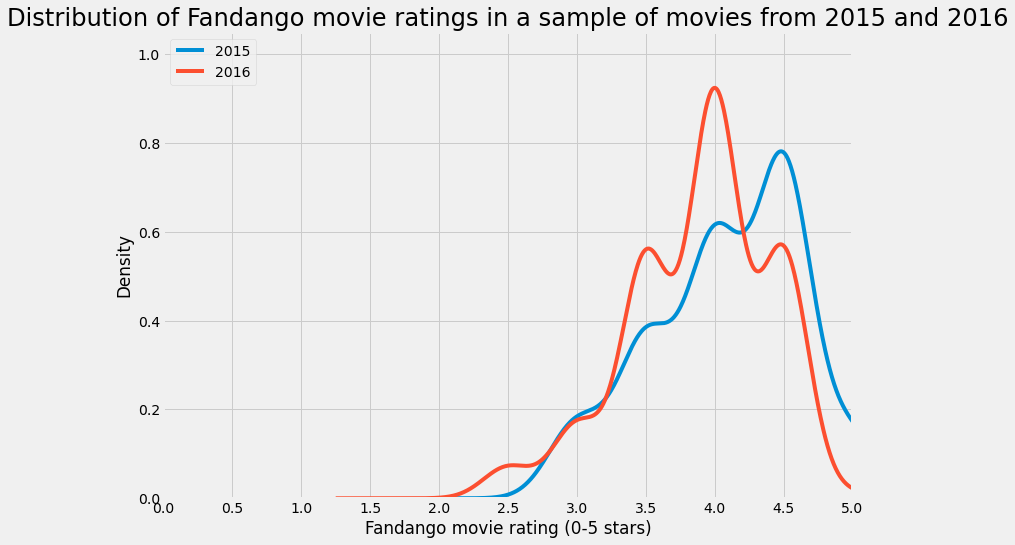

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

xtick_labels = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
plt.style.use("fivethirtyeight")

mr_15["Fandango_Stars"].plot.kde(figsize=(11, 8))
mr_16["fandango"].plot.kde(figsize=(11, 8))
plt.title("Distribution of Fandango movie ratings in a sample of movies from 2015 and 2016", size="xx-large")
plt.xlabel("Fandango movie rating (0-5 stars)")
plt.ylabel("Density")
plt.legend([2015, 2016], loc="upper left")
plt.xlim(0, 5)
plt.ylim(0, 1.05)
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xticks(xtick_labels)
plt.show()

From the plot we can see that:

- the two distributions are both skewed to the left, although the 2016 distribution appears a little less skewed than the 2015 distribution;
- the 2015 distribution appears more shifted to the right compared to the 2016 distribution: this suggests that 2015 movies tend to have higher ratings compared to 2016 movies;
- the 2016 distribution indeed shows more movies rated between 3.5 and 4.0 stars and less movies rated higher than 4.0 compared to the 2015 distribution.

To confirm these findings, let's also analyze the two relative frequency distribution tables: 

In [13]:
mr_15_freq = mr_15["Fandango_Stars"].value_counts(normalize=True).sort_index(ascending=False)
print("Relative frequency distribution table for the 2015 movies:", mr_15_freq)

mr_16_freq = mr_16["fandango"].value_counts(normalize=True).sort_index(ascending=False)
print("\nRelative frequency distribution table for the 2016 movies:", mr_16_freq)

Relative frequency distribution table for the 2015 movies: 5.0    0.069767
4.5    0.379845
4.0    0.286822
3.5    0.178295
3.0    0.085271
Name: Fandango_Stars, dtype: float64

Relative frequency distribution table for the 2016 movies: 5.0    0.005236
4.5    0.246073
4.0    0.403141
3.5    0.240838
3.0    0.073298
2.5    0.031414
Name: fandango, dtype: float64


The frequency tables indeed confirm our findings: there are less movies rated 5.0 and 4.5 stars in the 2016 sample than it is the case in the 2015 one; furthermore, movies rated 3.5 stars or less are more common in the 2016 distribution, and for the first time we can also see that about 3% of the movies are rated 2.5 stars out of five: this class of rating is completely missing in the 2015 distribution, where the lowest score is 3.0 stars.

To sum it up, let's compute some summary statistics (mean, median and mode) for our two distributions and plot them for comparison purposes:

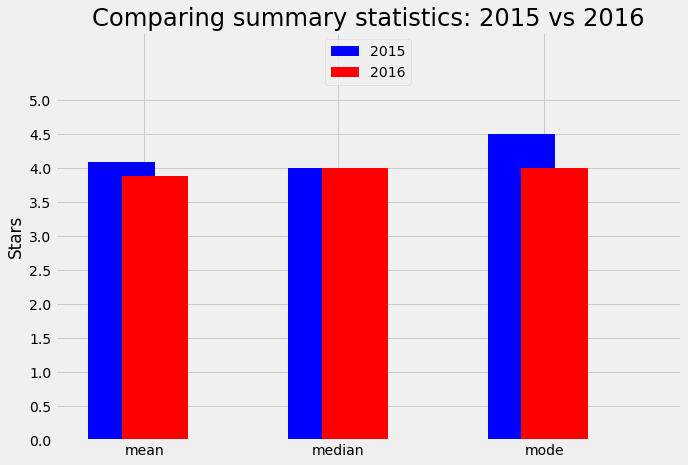

The mean between 2015 and 2016 has seen a slight decrease of 0.2 stars
The mode between 2015 and 2016 has seen a decrease of 0.5 stars


In [14]:
# computing the statistics and storing them into lists
mean_15 = mr_15["Fandango_Stars"].mean()
median_15 = mr_15["Fandango_Stars"].median()
mode_15 = float(mr_15["Fandango_Stars"].mode())

mean_16 = mr_16["fandango"].mean()
median_16 = mr_16["fandango"].median()
mode_16 = float(mr_16["fandango"].mode())

stats_15 = [mean_15, median_15, mode_15]
stats_16 = [mean_16, median_16, mode_16]

# plotting the lists
labels = ["mean", "median", "mode"] # labels for the xticks
pos1 = [0.5, 2, 3.5] # positions of the 2015 bars
pos2 = [0.75, 2.25, 3.75] # positions of the 2016 bars

fig, ax = plt.subplots(figsize=(10, 7))
ax.bar(pos1, stats_15, width=0.5, label="2015", color="blue")
ax.bar(pos2, stats_16, width=0.5, label="2016", color="red")
plt.ylabel("Stars")
plt.title("Comparing summary statistics: 2015 vs 2016", size="xx-large")
plt.legend([2015, 2016])
plt.xticks([0.67, 2.125, 3.67], labels) # positions and labels for the xticks
plt.yticks(np.arange(0, 5.5, 0.5)) # positions for the yticks
plt.xlim(0, 4.7)
plt.ylim(0, 6)
plt.legend(loc="upper center")
plt.show()

print("The mean between 2015 and 2016 has seen a slight decrease of {0} stars".format(round(mean_15 - mean_16, 2)))
print("The mode between 2015 and 2016 has seen a decrease of {0} stars".format(mode_15 - mode_16))

As we can see, while the median between the two distributions is exactly the same, mean and mode have seen a decrease going from 2015 to 2016: this suggests that there are less extremely high values in the 2016 sample compared to the 2015 sample.

We can also see that the median in the 2016 distribution is actually higher than the mean (this is not the case in the 2015 distributions), which indicates that there are more extremely low values in 2016 than there were in 2015.

## Conclusion

Thanks to our analysis we could find out that there was indeed a change in the Fandango's movie rating system after Walt Hickey's article appeared on FiveThirtyEight: movies published in 2016 tended to be rated less positively than what was the case in 2015.

Although the change was not extremely big, it still was positive progress towards a less biased way of rating movies.